# Unsupervised Learning Clustering

The object of this clustering analysis is to see if any interesting relationships exist in the wildfire dataset. Unlike supervised learning, in unsupervised learning there is no target to predict but rather we look for cateogries from the structure in our data. This approach is often used in marketing research.

My methodolgy includes the following steps:
- Standarize the data
- Consolidate the features using principal component analysis
- Determine the optimal number of K clusters using the elbow method
- Instantiate a K Means model
- Observe the results with a scatter plot
- Evaluate the result with a cluster report

methodology: https://archive.is/5DVOX#selection-1449.0-3381.3

## Import Libraries

In [22]:
import pandas as pd
import numpy as np

from sklearn import cluster
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

from sklearn import metrics
from scipy.spatial.distance import cdist

from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot') 

import seaborn as sns

import time

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [2]:
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)

## Import Data

In [3]:
df = pd.read_csv('../data/california.csv', low_memory=False)
df.drop(columns='Unnamed: 0', inplace=True)
df.head(3)

,nwcg_reporting_unit_name,fire_name,complex_name,fire_year,discovery_doy,discovery_time,stat_cause_descr,cont_doy,cont_time,fire_size,fire_size_class,latitude,longitude,state,county,discovery_date,cont_date,discovery_month,discovery_day_of_week,cont_month,cont_day_of_week,discovery_day_of_week_word,cont_day_of_week_word
0,Plumas National Forest,FOUNTAIN,NaN,2005,33,1300.0,Miscellaneous,33.0,1730.0,0.10,A,40.036944,-121.005833,CA,63,2005-02-02,2005-02-02,2,2,2.0,2.0,wednesday,wednesday
1,Eldorado National Forest,PIGEON,NaN,2004,133,845.0,Lightning,133.0,1530.0,0.25,A,38.933056,-120.404444,CA,61,2004-05-12,2004-05-12,5,2,5.0,2.0,wednesday,wednesday
2,Eldorado National Forest,SLACK,NaN,2004,152,1921.0,Debris Burning,152.0,2024.0,0.10,A,38.984167,-120.735556,CA,17,2004-05-31,2004-05-31,5,0,5.0,0.0,monday,monday


In [4]:
df['stat_cause_descr_code'] = df['stat_cause_descr'].map({'Miscellaneous':0,
                                                                'Equipment Use':1,
                                                                'Lightning':2,
                                                               'Arson': 3 ,
                                                               'Debris Burning':4, 
                                                               'Missing/Undefined': 5, 
                                                               'Campfire': 6, 
                                                               'Children': 7,
                                                               'Smoking':8, 
                                                               'Powerline':9, 
                                                               'Railroad':10, 
                                                               'Fireworks':11, 
                                                               'Structure':12
                                                              })

In [5]:
df.head(3)

,nwcg_reporting_unit_name,fire_name,complex_name,fire_year,discovery_doy,discovery_time,stat_cause_descr,cont_doy,cont_time,fire_size,fire_size_class,latitude,longitude,state,county,discovery_date,cont_date,discovery_month,discovery_day_of_week,cont_month,cont_day_of_week,discovery_day_of_week_word,cont_day_of_week_word,stat_cause_descr_code
0,Plumas National Forest,FOUNTAIN,NaN,2005,33,1300.0,Miscellaneous,33.0,1730.0,0.10,A,40.036944,-121.005833,CA,63,2005-02-02,2005-02-02,2,2,2.0,2.0,wednesday,wednesday,0
1,Eldorado National Forest,PIGEON,NaN,2004,133,845.0,Lightning,133.0,1530.0,0.25,A,38.933056,-120.404444,CA,61,2004-05-12,2004-05-12,5,2,5.0,2.0,wednesday,wednesday,2
2,Eldorado National Forest,SLACK,NaN,2004,152,1921.0,Debris Burning,152.0,2024.0,0.10,A,38.984167,-120.735556,CA,17,2004-05-31,2004-05-31,5,0,5.0,0.0,monday,monday,4


## Feature Selection

In [6]:
features = ['fire_year',
            'discovery_doy',
            'discovery_day_of_week',
            'discovery_month',
            'fire_size',
            'latitude',
            'longitude']

In [12]:
df[features].iloc[:,1:].corr()

,discovery_doy,discovery_day_of_week,discovery_month,fire_size,latitude,longitude
discovery_doy,1.000000,-0.000580,0.990865,0.009892,0.075918,-0.070220
discovery_day_of_week,-0.000580,1.000000,-0.000047,0.005439,-0.014720,0.013161
discovery_month,0.990865,-0.000047,1.000000,0.008892,0.074711,-0.069594
fire_size,0.009892,0.005439,0.008892,1.000000,-0.003499,0.002813
latitude,0.075918,-0.014720,0.074711,-0.003499,1.000000,-0.876954
longitude,-0.070220,0.013161,-0.069594,0.002813,-0.876954,1.000000


In [7]:
X = df[features]
y = df.stat_cause_descr_code

## Scaled Data

In [8]:
# Scaled X
ss = StandardScaler()
X_sc = ss.fit_transform(X)

## Principal Components Analysis (PCA)

PCA is a very popular technique for performing "dimensionality reduction" on your data.
Dimensionality reduction is the process of combining or collapsing your existing features (columns in X) into new features that not only retain the original information (or as much of it as we can) but also ideally reduce noise.

Intuitively, PCA transforms the coordinate system so that the axes become the most concise, informative descriptors of our data as a whole.

In [33]:
pca_df = pd.DataFrame(pca.transform(X_sc))
pca_df.head()
pca_features = [0, 1]
pca_df[pca_features]

,0,1
0,2.401033,-2.711447
1,0.942759,-1.188757
2,0.695444,-1.202646
3,0.379235,-0.546541
4,0.375754,-0.551985
...,...,...
189545,-1.808928,-0.787245
189546,-1.508287,0.443496
189547,1.283866,-1.261394
189548,-1.579483,0.512156


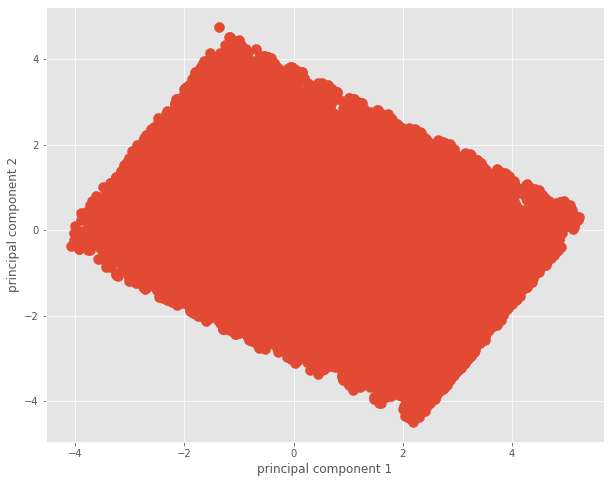

In [32]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(pca_df.iloc[:,0], pca_df.iloc[:,1], s=100)
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2');

In [13]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_sc)

In [14]:
pca.explained_variance_ratio_

array([0.29956313, 0.2558088 , 0.14465233, 0.14205651, 0.13907965,
       0.01753549, 0.00130409])

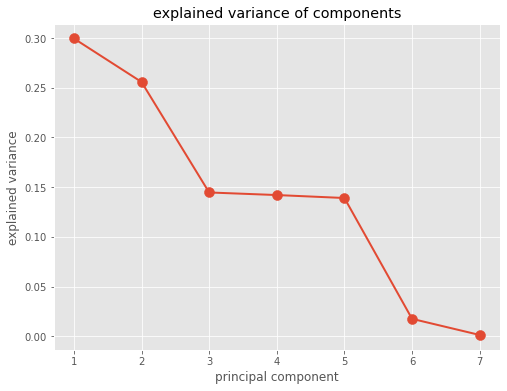

In [16]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(1,8), pca.explained_variance_ratio_, lw=2)
ax.scatter(range(1, 8), pca.explained_variance_ratio_, s=100)
ax.set_title('explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance');

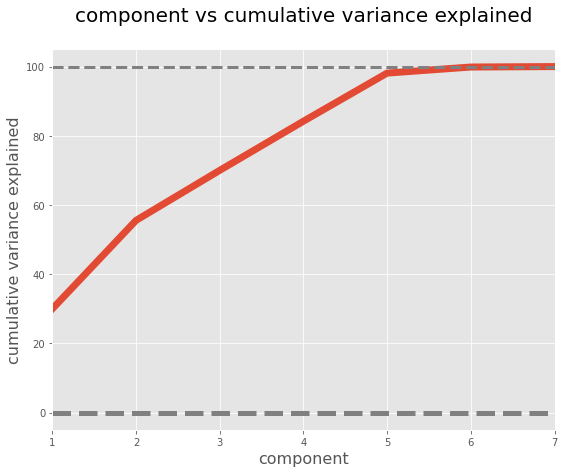

In [17]:
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)*100
plt.figure(figsize=(9,7))
component_number = range(1,8)
plt.plot(component_number, cum_var_exp, lw=7)
plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=100, linewidth=3, color='grey', ls='dashed')
ax = plt.gca()
ax.set_xlim([1,7])
ax.set_ylim([-5,105])
ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)  
ax.set_title('component vs cumulative variance explained\n', fontsize=20);

In [21]:
pca1_evec = pca.components_[0]
for weight, event in zip(pca1_evec, df[features].iloc[:,1:].columns):
    print(event, weight)

discovery_doy 0.07988196635617201
discovery_day_of_week -0.5922127501213253
discovery_month 0.010790431146072657
fire_size -0.5917494051263829
latitude -0.007278445195783565
longitude -0.38454636521665764


In [20]:
pca1_evec = pca.components_[1]
for weight, event in zip(pca1_evec, df[features].iloc[:,1:].columns):
    print(event, weight)

discovery_doy -0.1216145123301476
discovery_day_of_week 0.3748343253367339
discovery_month 0.01908287305205791
fire_size 0.375227169914092
latitude 0.012499230694390113
longitude -0.5910076856896682


## Elbow Method - Optimal Number of K Clusters

In [34]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(pca_df[pca_features])
    kmeanModel.fit(X_sc)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_
    
# code --> https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

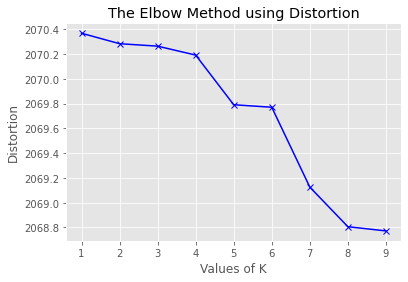

In [35]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [26]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 1326849.9999999958
2 : 1062088.0079606231
3 : 908699.8925658895
4 : 792567.3593510791
5 : 713067.0416043984
6 : 648499.7113887711
7 : 599954.5555268112
8 : 563247.9275198226
9 : 531979.3364089291


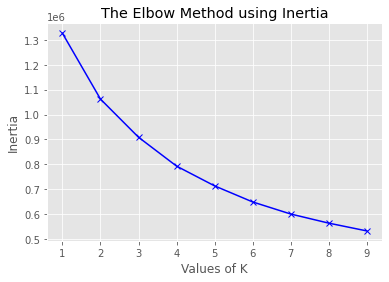

In [27]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

## K Means Model

In [38]:
# 8 Clusters
k_mean = KMeans(n_clusters=8)
k_mean.fit(pca_df[pca_features])

labels = k_mean.labels_
clusters = k_mean.cluster_centers_

start_time = time.time()

print(silhouette_score(pca_df[pca_features], labels))

end_time = time.time()
print()
print('Took %s seconds to calculate.' % (end_time - start_time))


0.36350155337478085

Took 382.0425298213959 seconds to calculate.


In [48]:
labels

array([4, 4, 7, ..., 4, 3, 2], dtype=int32)

## Scatter Plot

''

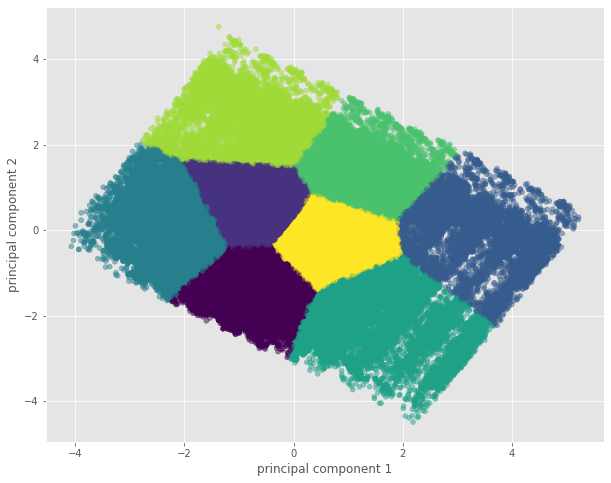

In [53]:
fig, ax = plt.subplots(figsize=(10,8))
# colors = ['red', 'blue']
# post = ['not WR', 'WR']
ax.scatter(pca_df.iloc[:,0], pca_df.iloc[:,1], s=25, c = labels, alpha=0.5)

ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')
# ax.legend(labels)
;

<ipython-input-62-763a1aec59b8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2['clusters']=labels



Took 238.09416699409485 seconds to calculate.


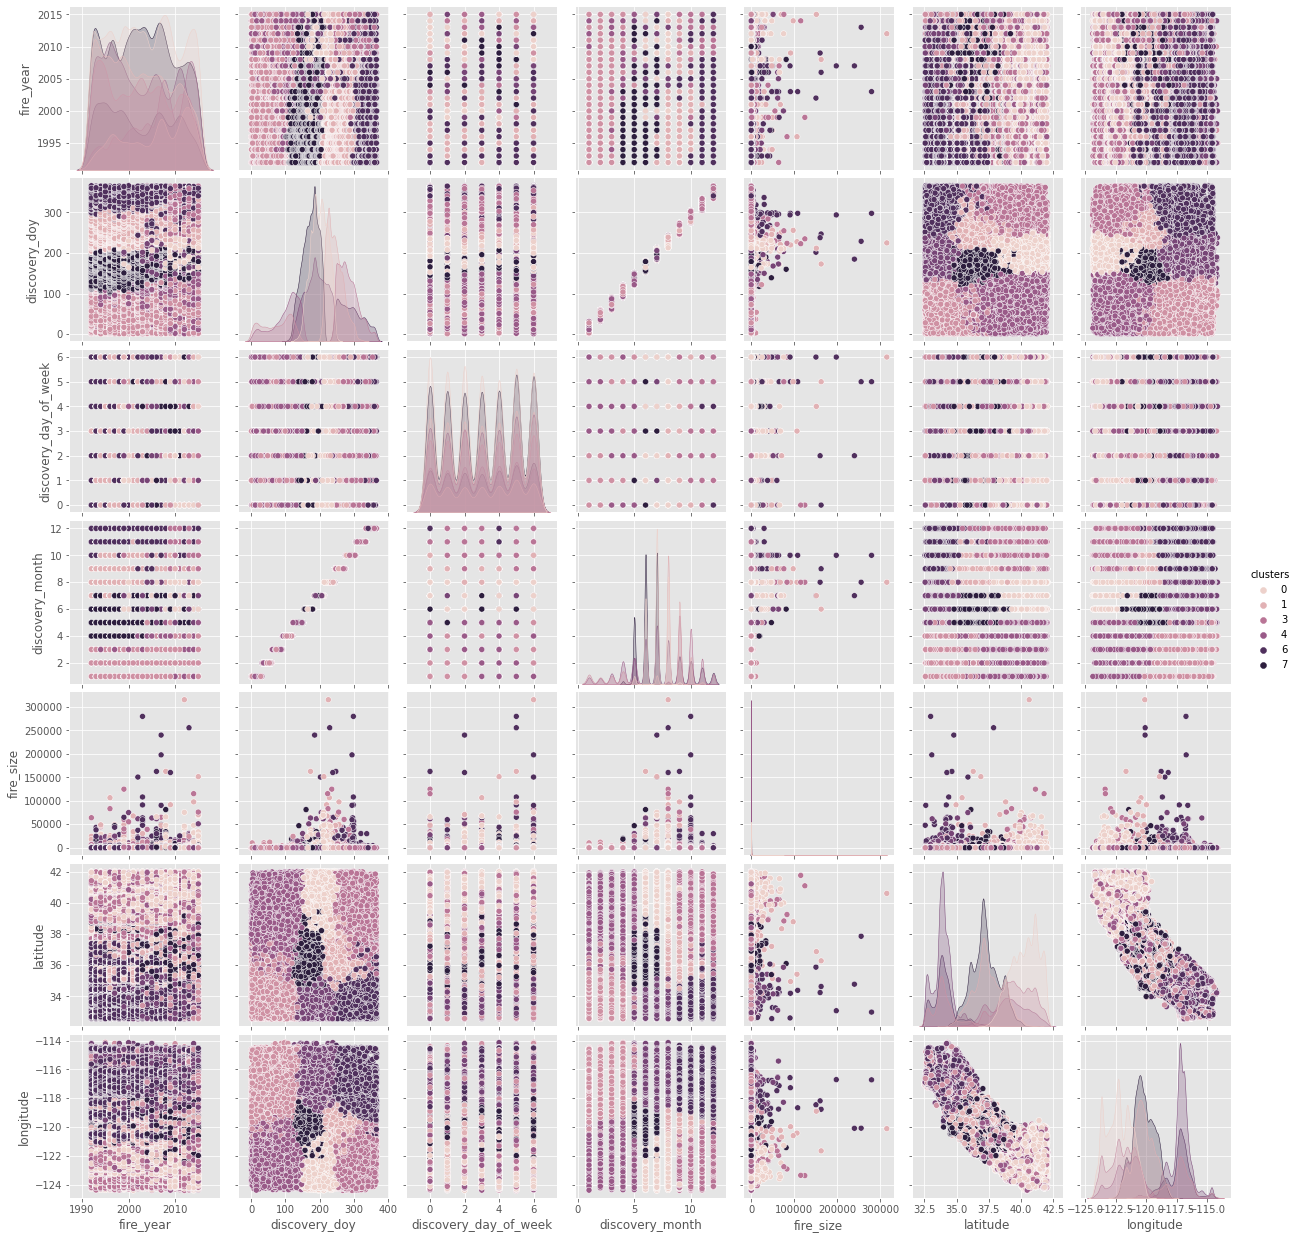

In [62]:
# visually examine the cluster that have been created
start_time = time.time()

X_2 = df[features]
X_2['clusters']=labels

sns.pairplot(data=X_2, hue='clusters')

end_time = time.time()
print()
print('Took %s seconds to calculate.' % (end_time - start_time))

## Cluster Report

In [54]:
from IPython.display import display, HTML
from sklearn.tree import _tree, DecisionTreeClassifier
import pandas as pd

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def get_class_rules(tree: DecisionTreeClassifier, feature_names: list):
  inner_tree: _tree.Tree = tree.tree_
  classes = tree.classes_
  class_rules_dict = dict()

  def tree_dfs(node_id=0, current_rule=[]):
    # feature[i] holds the feature to split on, for the internal node i.
    split_feature = inner_tree.feature[node_id]
    if split_feature != _tree.TREE_UNDEFINED: # internal node
      name = feature_names[split_feature]
      threshold = inner_tree.threshold[node_id]
      # left child
      left_rule = current_rule + ["({} <= {})".format(name, threshold)]
      tree_dfs(inner_tree.children_left[node_id], left_rule)
      # right child
      right_rule = current_rule + ["({} > {})".format(name, threshold)]
      tree_dfs(inner_tree.children_right[node_id], right_rule)
    else: # leaf
      dist = inner_tree.value[node_id][0]
      dist = dist/dist.sum()
      max_idx = dist.argmax()
      if len(current_rule) == 0:
        rule_string = "ALL"
      else:
        rule_string = " and ".join(current_rule)
      # register new rule to dictionary
      selected_class = classes[max_idx]
      class_probability = dist[max_idx]
      class_rules = class_rules_dict.get(selected_class, [])
      class_rules.append((rule_string, class_probability))
      class_rules_dict[selected_class] = class_rules
    
  tree_dfs() # start from root, node_id = 0
  return class_rules_dict

def cluster_report(data: pd.DataFrame, clusters, min_samples_leaf=50, pruning_level=0.01):
    # Create Model
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, ccp_alpha=pruning_level)
    tree.fit(data, clusters)
    
    # Generate Report
    feature_names = data.columns
    class_rule_dict = get_class_rules(tree, feature_names)

    report_class_list = []
    for class_name in class_rule_dict.keys():
        rule_list = class_rule_dict[class_name]
        combined_string = ""
        for rule in rule_list:
            combined_string += "[{}] {}\n\n".format(rule[1], rule[0])
        report_class_list.append((class_name, combined_string))
        
    cluster_instance_df = pd.Series(clusters).value_counts().reset_index()
    cluster_instance_df.columns = ['class_name', 'instance_count']
    report_df = pd.DataFrame(report_class_list, columns=['class_name', 'rule_list'])
    report_df = pd.merge(cluster_instance_df, report_df, on='class_name', how='left')
    pretty_print(report_df.sort_values(by='class_name')[['class_name', 'instance_count', 'rule_list']])
    
# code --> https://archive.is/5DVOX#selection-1449.0-3381.3

In [64]:
cluster_report(df[features], labels)

,class_name,instance_count,rule_list
0,0,38963,[0.6957637997432606] (latitude > 34.98509407043457) and (discovery_month <= 7.5) and (latitude <= 38.9417610168457) and (discovery_month > 4.5) and (longitude <= -122.01220703125)[0.9246392303580973] (latitude > 34.98509407043457) and (discovery_month <= 7.5) and (latitude > 38.9417610168457) and (discovery_doy > 151.5)[0.8317244764397905] (latitude > 34.98509407043457) and (discovery_month > 7.5) and (discovery_month <= 8.5) and (latitude > 38.99334144592285)
2,1,27573,[0.8639904554705593] (latitude > 34.98509407043457) and (discovery_month > 7.5) and (discovery_month <= 8.5) and (latitude <= 38.99334144592285)[0.8080060549995796] (latitude > 34.98509407043457) and (discovery_month > 7.5) and (discovery_month > 8.5) and (latitude <= 38.204734802246094) and (discovery_month <= 10.5)
7,2,9952,[0.970462004544307] (latitude <= 34.98509407043457) and (discovery_month <= 8.5) and (discovery_doy <= 124.5)
4,3,22578,[0.5958477508650519] (latitude > 34.98509407043457) and (discovery_month > 7.5) and (discovery_month > 8.5) and (latitude <= 38.204734802246094) and (discovery_month > 10.5)[0.881163434903047] (latitude > 34.98509407043457) and (discovery_month > 7.5) and (discovery_month > 8.5) and (latitude > 38.204734802246094)
5,4,14881,[0.7558772935779816] (latitude > 34.98509407043457) and (discovery_month <= 7.5) and (latitude <= 38.9417610168457) and (discovery_month <= 4.5)[0.8723203769140165] (latitude > 34.98509407043457) and (discovery_month <= 7.5) and (latitude > 38.9417610168457) and (discovery_doy <= 151.5)
3,5,25826,[0.9376081825334383] (latitude <= 34.98509407043457) and (discovery_month <= 8.5) and (discovery_doy > 124.5)
6,6,14361,[0.9879896824117362] (latitude <= 34.98509407043457) and (discovery_month > 8.5)
1,7,35416,[0.8661703042683583] (latitude > 34.98509407043457) and (discovery_month <= 7.5) and (latitude <= 38.9417610168457) and (discovery_month > 4.5) and (longitude > -122.01220703125)


The interpretability is not high. Hard to make sense out of the report. 

In [ ]:
.describe

In [ ]:
groupby()